In [1]:
# Import all the required libraries and machine learning models

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, BatchNormalization, Dropout # LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import xgboost as xgb
from catboost import CatBoostClassifier
from matplotlib import pyplot

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Using TensorFlow backend.


In [2]:
# Import the data files for further analysis

df = pd.read_csv('train.csv')               # Original train data set
pca_train = pd.read_csv('pca_train.csv')    # Principal Components collected for train data set. See ->
pca_test = pd.read_csv('pca_test.csv')      # Prinscipal Components collected for test data set. See ->
alldf = pd.read_csv('allpca.csv')          # The whole Train-Test dataset in combined form
alldf.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban


In [3]:
## Data Pre-processing!
# Convert the categorical variables to numbers and take care of null values

df1 = alldf.copy(deep=True)
df1['Gender'] = df1['Gender'].map(lambda x: 1 if x == 'Male' else 0)
df1['Married'] = df1['Married'].map(lambda x: 1 if x == 'Yes' else 0)
df1['Dependents'] = df1['Dependents'].map(lambda x: 3 if x == '3+' else float(x))
df1['Dependents'] = df1['Dependents'].fillna(df1['Dependents'].mean())#value=0)
df1['Education'] = df1['Education'].map(lambda x: 1 if x == 'Graduate' else 0)
df1['Self_Employed'] = df1['Self_Employed'].map(lambda x: 1 if x == 'Yes' else 0)
df1['LoanAmount'] = df1['LoanAmount'].fillna(df1['LoanAmount'].mean())
df1['Loan_Amount_Term'] = df1['Loan_Amount_Term'].fillna(df1['Loan_Amount_Term'].mean())
df1['Credit_History'] = df1['Credit_History'].fillna(df1['Credit_History'].mean())
df1['Property_Area'] = df1['Property_Area'].map(lambda x: 2 if x == 'Urban' else (1 if x == 'Semiurban' else 0))
#df1['Loan_Status'] = df1['Loan_Status'].map(lambda x: 1 if x == 'Y' else 0)
df1.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001002,1,0,0.0,1,0,5849,0.0,142.51153,360.0,1.0,2
1,LP001003,1,1,1.0,1,0,4583,1508.0,128.00000,360.0,1.0,0
2,LP001005,1,1,0.0,1,1,3000,0.0,66.00000,360.0,1.0,2
3,LP001006,1,1,0.0,0,0,2583,2358.0,120.00000,360.0,1.0,2
4,LP001008,1,0,0.0,1,0,6000,0.0,141.00000,360.0,1.0,2


In [4]:
# Check the structure of the data in all-dataset (First 614 rows train, last 367 rows test)
alldf.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban


In [5]:
# Check the princinpal components for training set obtained from PCA analysis explained in the other file
pca_train.head()

,pc1,pc2,pc3,pc4,pc5,pc6
0,0.532196,-0.372043,0.305666,-0.546590,0.135447,0.009730
1,-0.389258,-0.045656,-0.573600,-0.017898,-0.057655,-0.232852
2,-0.293952,-0.467042,0.134255,-0.177374,-0.261998,0.795718
3,-0.378499,0.394433,0.677732,-0.340884,-0.220230,-0.150057
4,0.532253,-0.371999,0.305718,-0.546631,0.135432,0.009699


In [6]:
# Similarly check PCs for test dataset
pca_test.head()

,pc1,pc2,pc3,pc4,pc5,pc6
0,-0.279674,-0.482089,0.281351,-0.216091,-0.031365,-0.142948
1,-0.387792,-0.465299,0.315794,-0.105767,-0.045882,-0.094015
2,-0.499361,-0.453305,0.346596,0.008040,-0.060596,-0.039688
3,-0.492062,-0.414947,0.365367,0.070814,0.079475,-0.018593
4,0.437441,0.509004,0.706130,-0.674169,-0.054470,-0.001153


In [7]:
# Convert labels from categorical Y/N to binary numbers for Loan Elibiligy Classification
df['Loan_Status'] = df['Loan_Status'].map(lambda x: 1 if x == 'Y' else 0)

In [8]:
# Set X, y and t to input variables, target variable and test set respectively 

X = pca_train[['pc1','pc2','pc3','pc4','pc5','pc6']]       # PCs for train set
y = df['Loan_Status']                                      # Target for train set
t = pca_test[['pc1','pc2','pc3','pc4','pc5','pc6']]        # PCs for the test set
#y = to_categorical(y)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

In [9]:
t.shape

(367, 6)

In [10]:
X.shape

(614, 6)

In [11]:
# Define a stacking function to create predictions on the train and test data set using ML models/classifiers

def Stacking(model, train, y, test, n_fold):              # Takes input as model, X_train, y_train, t (test data) and number of folds for cross-validation
    folds = StratifiedKFold(n_splits = n_fold, random_state=1)
    test_pred = np.empty((0,1), float)
    train_pred = np.empty((0,1), float)
    train_targ = np.empty((0,1), float)
    i = 0
    for train_indices, val_indices in folds.split(train, y.values):
        X_train, X_val = train.loc[train_indices], train.loc[val_indices]
        y_train, y_val = y.loc[train_indices], y.loc[val_indices]

        model.fit(X_train, y_train)
        train_pred = np.append(train_pred, model.predict(X_val))    # Append the predictions made on the validation set in each fold
        train_targ = np.append(train_targ, y_val)                   # Append the corresponding validation targets
        i+=1
        print(f'Fold {i} - Validation Accuracy: ', model.score(X_val, y_val))                            # These predictions from ML models will be used as input in the Deep Learning model
    test_pred = np.append(test_pred, model.predict(t))              # This is how ML over DL Stacking Ensemble is created 
    return test_pred, train_pred, train_targ                        

In [12]:
# Create Ada classifier and create a new input variable 'ada' made out of validation fold predictions
# As these predictions are made on the data unseen by the model as it goes through each fold,
# it makes it a good unbiased input to be used in the ensemble of the machine/deep learning models

ada = AdaBoostClassifier(n_estimators=1)

# Train ada classifier and create input validation preditions using Stacking function
test_pred1, train_pred1, train_targ1 = Stacking(ada, X, y, t, 10)

# Create a ML_train_pred dataframe to store the corresponding targets
ML_train_pred = pd.DataFrame(train_targ1, columns=['target'])

# Add 'ada' column as preditions made on the validation set during the ML training
ML_train_pred['ada'] = train_pred1

# Similarly add preditions made on the test set using ada in a new ML_test_pred dataframe
ML_test_pred = pd.DataFrame(test_pred1,columns=['ada'])
ML_train_pred.head()

Fold 1 - Validation Accuracy:  0.7777777777777778
Fold 2 - Validation Accuracy:  0.8412698412698413
Fold 3 - Validation Accuracy:  0.7868852459016393
Fold 4 - Validation Accuracy:  0.7704918032786885
Fold 5 - Validation Accuracy:  0.7868852459016393
Fold 6 - Validation Accuracy:  0.7868852459016393
Fold 7 - Validation Accuracy:  0.8852459016393442
Fold 8 - Validation Accuracy:  0.8524590163934426
Fold 9 - Validation Accuracy:  0.819672131147541
Fold 10 - Validation Accuracy:  0.819672131147541


,target,ada
0,1.0,1.0
1,0.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0


In [13]:
# Check head and tail for consistency
ML_train_pred.tail()

,target,ada
609,1.0,1.0
610,1.0,1.0
611,1.0,1.0
612,1.0,1.0
613,0.0,0.0


In [14]:
# Check the length of the df
len(train_pred1)

614

In [15]:
# Follow the similar process as that for AdaClassifier but using different machine learning algorythms
# GradientBoostingClassifier

gbc = GradientBoostingClassifier(learning_rate=0.005,warm_start=True, n_estimators=176)

test_pred1, train_pred1, train_targ1 = Stacking(gbc, X, y, t, 10)

ML_train_pred['gbc'] = train_pred1
ML_test_pred['gbc'] = test_pred1
ML_train_pred.head()

Fold 1 - Validation Accuracy:  0.7777777777777778
Fold 2 - Validation Accuracy:  0.8888888888888888
Fold 3 - Validation Accuracy:  0.8360655737704918
Fold 4 - Validation Accuracy:  0.7704918032786885
Fold 5 - Validation Accuracy:  0.8032786885245902
Fold 6 - Validation Accuracy:  0.8032786885245902
Fold 7 - Validation Accuracy:  0.8852459016393442
Fold 8 - Validation Accuracy:  0.8524590163934426
Fold 9 - Validation Accuracy:  0.819672131147541
Fold 10 - Validation Accuracy:  0.8524590163934426


,target,ada,gbc
0,1.0,1.0,1.0
1,0.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0


In [16]:
# BaggingClassifier using DecisionTreeClassifier as the Best Estimator parameter

bcdt = BaggingClassifier(DecisionTreeClassifier(random_state=1), n_estimators=43)

test_pred1, train_pred1, train_targ1 = Stacking(bcdt, X, y, t, 10)

ML_train_pred['bcdt'] = train_pred1
ML_test_pred['bcdt'] = test_pred1
ML_train_pred.head()

Fold 1 - Validation Accuracy:  0.6825396825396826
Fold 2 - Validation Accuracy:  0.7619047619047619
Fold 3 - Validation Accuracy:  0.6721311475409836
Fold 4 - Validation Accuracy:  0.7377049180327869
Fold 5 - Validation Accuracy:  0.7049180327868853
Fold 6 - Validation Accuracy:  0.7213114754098361
Fold 7 - Validation Accuracy:  0.8032786885245902
Fold 8 - Validation Accuracy:  0.7540983606557377
Fold 9 - Validation Accuracy:  0.6885245901639344
Fold 10 - Validation Accuracy:  0.7704918032786885


,target,ada,gbc,bcdt
0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0


In [17]:
# DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=1)

test_pred1, train_pred1, train_targ1 = Stacking(dt, X, y, t, 10)

ML_train_pred['dt'] = train_pred1
ML_test_pred['dt'] = test_pred1
ML_train_pred.head()

Fold 1 - Validation Accuracy:  0.6825396825396826
Fold 2 - Validation Accuracy:  0.6666666666666666
Fold 3 - Validation Accuracy:  0.6557377049180327
Fold 4 - Validation Accuracy:  0.7213114754098361
Fold 5 - Validation Accuracy:  0.7213114754098361
Fold 6 - Validation Accuracy:  0.7540983606557377
Fold 7 - Validation Accuracy:  0.7540983606557377
Fold 8 - Validation Accuracy:  0.6065573770491803
Fold 9 - Validation Accuracy:  0.6229508196721312
Fold 10 - Validation Accuracy:  0.7704918032786885


,target,ada,gbc,bcdt,dt
0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0


In [18]:
ML_test_pred.tail()

,ada,gbc,bcdt,dt
362,1.0,1.0,1.0,1.0
363,1.0,1.0,1.0,1.0
364,0.0,0.0,0.0,0.0
365,1.0,1.0,1.0,1.0
366,1.0,1.0,1.0,0.0


In [19]:
# LinearSVC

svc = LinearSVC(random_state=1)

test_pred1, train_pred1, train_targ1 = Stacking(svc, X, y, t, 10)

ML_train_pred['svc'] = train_pred1
ML_test_pred['svc'] = test_pred1
ML_train_pred.head()

Fold 1 - Validation Accuracy:  0.7936507936507936
Fold 2 - Validation Accuracy:  0.8253968253968254
Fold 3 - Validation Accuracy:  0.7868852459016393
Fold 4 - Validation Accuracy:  0.7540983606557377
Fold 5 - Validation Accuracy:  0.7868852459016393
Fold 6 - Validation Accuracy:  0.7868852459016393
Fold 7 - Validation Accuracy:  0.8688524590163934
Fold 8 - Validation Accuracy:  0.8524590163934426
Fold 9 - Validation Accuracy:  0.8032786885245902
Fold 10 - Validation Accuracy:  0.8360655737704918


,target,ada,gbc,bcdt,dt,svc
0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0


In [20]:
ML_test_pred.tail()

,ada,gbc,bcdt,dt,svc
362,1.0,1.0,1.0,1.0,1.0
363,1.0,1.0,1.0,1.0,1.0
364,0.0,0.0,0.0,0.0,1.0
365,1.0,1.0,1.0,1.0,1.0
366,1.0,1.0,1.0,0.0,1.0


In [21]:
# XGBM Boosting Ensemble Classifier

xg = xgb.XGBClassifier(random_state=1,learning_rate=0.005)

test_pred1, train_pred1, train_targ1 = Stacking(xg, X, y, t, 10)

ML_train_pred['xg'] = train_pred1
ML_test_pred['xg'] = test_pred1
ML_train_pred.head()

Fold 1 - Validation Accuracy:  0.7777777777777778
Fold 2 - Validation Accuracy:  0.8412698412698413
Fold 3 - Validation Accuracy:  0.7868852459016393
Fold 4 - Validation Accuracy:  0.7704918032786885
Fold 5 - Validation Accuracy:  0.7377049180327869
Fold 6 - Validation Accuracy:  0.7868852459016393
Fold 7 - Validation Accuracy:  0.8852459016393442
Fold 8 - Validation Accuracy:  0.8360655737704918
Fold 9 - Validation Accuracy:  0.819672131147541
Fold 10 - Validation Accuracy:  0.819672131147541


,target,ada,gbc,bcdt,dt,svc,xg
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [22]:
# CatBoostClassifier

cbc = CatBoostClassifier(random_state=1, iterations=50)

test_pred1, train_pred1, train_targ1 = Stacking(cbc, X, y, t, 10)

ML_train_pred['cbc'] = train_pred1
ML_test_pred['cbc'] = test_pred1
ML_train_pred.head()

Learning rate set to 0.124581
0:	learn: 0.6556097	total: 56.3ms	remaining: 2.76s
1:	learn: 0.6225240	total: 59ms	remaining: 1.42s
2:	learn: 0.5986340	total: 61.7ms	remaining: 967ms
3:	learn: 0.5759834	total: 65.6ms	remaining: 754ms
4:	learn: 0.5571535	total: 68.5ms	remaining: 617ms
5:	learn: 0.5420903	total: 71.4ms	remaining: 524ms
6:	learn: 0.5275879	total: 74.8ms	remaining: 460ms
7:	learn: 0.5160958	total: 77.9ms	remaining: 409ms
8:	learn: 0.5070416	total: 81.5ms	remaining: 371ms
9:	learn: 0.4992086	total: 84.8ms	remaining: 339ms
10:	learn: 0.4909218	total: 87.9ms	remaining: 312ms
11:	learn: 0.4843533	total: 90.9ms	remaining: 288ms
12:	learn: 0.4771698	total: 95.5ms	remaining: 272ms
13:	learn: 0.4720667	total: 98.3ms	remaining: 253ms
14:	learn: 0.4674413	total: 102ms	remaining: 238ms
15:	learn: 0.4621135	total: 105ms	remaining: 223ms
16:	learn: 0.4581469	total: 109ms	remaining: 211ms
17:	learn: 0.4544803	total: 112ms	remaining: 199ms
18:	learn: 0.4511867	total: 115ms	remaining: 187ms

22:	learn: 0.4387786	total: 132ms	remaining: 155ms
23:	learn: 0.4372409	total: 136ms	remaining: 147ms
24:	learn: 0.4355082	total: 139ms	remaining: 139ms
25:	learn: 0.4340754	total: 142ms	remaining: 131ms
26:	learn: 0.4327153	total: 145ms	remaining: 123ms
27:	learn: 0.4299409	total: 150ms	remaining: 118ms
28:	learn: 0.4283514	total: 154ms	remaining: 111ms
29:	learn: 0.4261927	total: 157ms	remaining: 105ms
30:	learn: 0.4240545	total: 161ms	remaining: 98.8ms
31:	learn: 0.4222526	total: 164ms	remaining: 92.3ms
32:	learn: 0.4211400	total: 168ms	remaining: 86.3ms
33:	learn: 0.4201321	total: 171ms	remaining: 80.3ms
34:	learn: 0.4184650	total: 174ms	remaining: 74.5ms
35:	learn: 0.4175101	total: 178ms	remaining: 69.4ms
36:	learn: 0.4162811	total: 182ms	remaining: 63.9ms
37:	learn: 0.4145325	total: 187ms	remaining: 58.9ms
38:	learn: 0.4133427	total: 190ms	remaining: 53.6ms
39:	learn: 0.4124422	total: 194ms	remaining: 48.4ms
40:	learn: 0.4112938	total: 200ms	remaining: 43.8ms
41:	learn: 0.4103604

48:	learn: 0.4247383	total: 255ms	remaining: 5.2ms
49:	learn: 0.4232447	total: 257ms	remaining: 0us
Fold 7 - Validation Accuracy:  0.8524590163934426
Learning rate set to 0.124773
0:	learn: 0.6566933	total: 4.96ms	remaining: 243ms
1:	learn: 0.6287660	total: 7.78ms	remaining: 187ms
2:	learn: 0.6041514	total: 10.9ms	remaining: 171ms
3:	learn: 0.5848756	total: 13.7ms	remaining: 157ms
4:	learn: 0.5656670	total: 19.1ms	remaining: 172ms
5:	learn: 0.5505046	total: 22ms	remaining: 161ms
6:	learn: 0.5376247	total: 24.8ms	remaining: 152ms
7:	learn: 0.5254178	total: 28.1ms	remaining: 148ms
8:	learn: 0.5149310	total: 31.9ms	remaining: 145ms
9:	learn: 0.5068453	total: 34.6ms	remaining: 139ms
10:	learn: 0.4998728	total: 37.7ms	remaining: 134ms
11:	learn: 0.4942271	total: 40.5ms	remaining: 128ms
12:	learn: 0.4871950	total: 43.3ms	remaining: 123ms
13:	learn: 0.4824274	total: 48.4ms	remaining: 125ms
14:	learn: 0.4775968	total: 51.2ms	remaining: 119ms
15:	learn: 0.4734813	total: 54.5ms	remaining: 116ms


,target,ada,gbc,bcdt,dt,svc,xg,cbc
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [23]:
# KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=15)

test_pred1, train_pred1, train_targ1 = Stacking(knn, X, y, t, 10)

ML_train_pred['knn'] = train_pred1
ML_test_pred['knn'] = test_pred1
ML_train_pred.head()

Fold 1 - Validation Accuracy:  0.7936507936507936
Fold 2 - Validation Accuracy:  0.8253968253968254
Fold 3 - Validation Accuracy:  0.7868852459016393
Fold 4 - Validation Accuracy:  0.7540983606557377
Fold 5 - Validation Accuracy:  0.7704918032786885
Fold 6 - Validation Accuracy:  0.7868852459016393
Fold 7 - Validation Accuracy:  0.8688524590163934
Fold 8 - Validation Accuracy:  0.8360655737704918
Fold 9 - Validation Accuracy:  0.8032786885245902
Fold 10 - Validation Accuracy:  0.8360655737704918


,target,ada,gbc,bcdt,dt,svc,xg,cbc,knn
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [24]:
# RandomForestClassifier

rf = RandomForestClassifier(n_estimators=250)

test_pred1, train_pred1, train_targ1 = Stacking(rf, X, y, t, 10)

ML_train_pred['rf'] = train_pred1
ML_test_pred['rf'] = test_pred1
ML_train_pred.head()

Fold 1 - Validation Accuracy:  0.7301587301587301
Fold 2 - Validation Accuracy:  0.7619047619047619
Fold 3 - Validation Accuracy:  0.7049180327868853
Fold 4 - Validation Accuracy:  0.7377049180327869
Fold 5 - Validation Accuracy:  0.7049180327868853
Fold 6 - Validation Accuracy:  0.7704918032786885
Fold 7 - Validation Accuracy:  0.7868852459016393
Fold 8 - Validation Accuracy:  0.7540983606557377
Fold 9 - Validation Accuracy:  0.6885245901639344
Fold 10 - Validation Accuracy:  0.819672131147541


,target,ada,gbc,bcdt,dt,svc,xg,cbc,knn,rf
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [25]:
# LogisticRegression

log = LogisticRegression(solver='lbfgs')

test_pred1, train_pred1, train_targ1 = Stacking(log, X, y, t, 10)

ML_train_pred['log'] = train_pred1
ML_test_pred['log'] = test_pred1
ML_train_pred.head()

Fold 1 - Validation Accuracy:  0.7936507936507936
Fold 2 - Validation Accuracy:  0.8253968253968254
Fold 3 - Validation Accuracy:  0.7868852459016393
Fold 4 - Validation Accuracy:  0.7540983606557377
Fold 5 - Validation Accuracy:  0.7868852459016393
Fold 6 - Validation Accuracy:  0.7868852459016393
Fold 7 - Validation Accuracy:  0.8688524590163934
Fold 8 - Validation Accuracy:  0.8524590163934426
Fold 9 - Validation Accuracy:  0.8032786885245902
Fold 10 - Validation Accuracy:  0.8360655737704918


,target,ada,gbc,bcdt,dt,svc,xg,cbc,knn,rf,log
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [26]:
# Create a single dataframe from all the train-test ML model predictions above
allML = pd.concat([ML_train_pred.drop(['target'],axis=1), ML_test_pred])
len(allML)

981

In [27]:
allML.tail()

,ada,gbc,bcdt,dt,svc,xg,cbc,knn,rf,log
362,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
363,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
364,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
365,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
366,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


In [28]:
# Use PCA to reduce the dimensions of the indepenent variables to 5 components
# Use these PCs as input in the Deep Learning model training thereby creating the second stage of Stacking Ensemble

scaler = MinMaxScaler()
pca = PCA(n_components=5)

# Separating out the features
features = ['ada','gbc','bcdt','dt','svc','xg','cbc','knn','rf','log']
Xpc = allML.loc[:, features].values

Xpc = scaler.fit_transform(Xpc)

principalComponents = pca.fit_transform(Xpc)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2','pc3','pc4','pc5'])
principalDf.head()

,pc1,pc2,pc3,pc4,pc5
0,-0.642876,0.174761,0.040048,0.000937,-0.002333
1,-0.642876,0.174761,0.040048,0.000937,-0.002333
2,-0.642876,0.174761,0.040048,0.000937,-0.002333
3,-0.642876,0.174761,0.040048,0.000937,-0.002333
4,-0.642876,0.174761,0.040048,0.000937,-0.002333


In [29]:
# Splitting the PCs for train and test dataset for further processing
l = [614,981]
l_mod = [0] + l + [max(l)+1]

train_test_dfs = [principalDf.iloc[l_mod[n]:l_mod[n+1]] for n in range(len(l_mod)-1)]

In [30]:
# The train PCs df to be used as input for DL model training
train_test_dfs[0]

,pc1,pc2,pc3,pc4,pc5
0,-0.642876,0.174761,0.040048,0.000937,-0.002333
1,-0.642876,0.174761,0.040048,0.000937,-0.002333
2,-0.642876,0.174761,0.040048,0.000937,-0.002333
3,-0.642876,0.174761,0.040048,0.000937,-0.002333
4,-0.642876,0.174761,0.040048,0.000937,-0.002333
...,...,...,...,...,...
609,-0.642876,0.174761,0.040048,0.000937,-0.002333
610,-0.642876,0.174761,0.040048,0.000937,-0.002333
611,-0.642876,0.174761,0.040048,0.000937,-0.002333
612,-0.642876,0.174761,0.040048,0.000937,-0.002333


In [31]:
# Splitting the input data into train-test set

input_X = ['pc1','pc2','pc3','pc4','pc5']

X = train_test_dfs[0].values
y = ML_train_pred['target']
y = to_categorical(y)
t = train_test_dfs[1].values        # princinpal components for test set to be used later as input for final predictions

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

Train on 496 samples, validate on 56 samples
Epoch 1/5000
 - 1s - loss: 0.2451 - acc: 0.6855 - val_loss: 0.2402 - val_acc: 0.6964

Epoch 00001: acc improved from -inf to 0.68548, saving model to DLBestEnsemble.hdf5
Epoch 2/5000
 - 0s - loss: 0.2422 - acc: 0.6754 - val_loss: 0.2321 - val_acc: 0.6964

Epoch 00002: acc did not improve from 0.68548
Epoch 3/5000
 - 0s - loss: 0.2340 - acc: 0.6915 - val_loss: 0.2241 - val_acc: 0.6964

Epoch 00003: acc improved from 0.68548 to 0.69153, saving model to DLBestEnsemble.hdf5
Epoch 4/5000
 - 0s - loss: 0.2286 - acc: 0.6875 - val_loss: 0.2163 - val_acc: 0.6964

Epoch 00004: acc did not improve from 0.69153
Epoch 5/5000
 - 0s - loss: 0.2229 - acc: 0.6875 - val_loss: 0.2090 - val_acc: 0.6964

Epoch 00005: acc did not improve from 0.69153
Epoch 6/5000
 - 0s - loss: 0.2169 - acc: 0.6996 - val_loss: 0.2021 - val_acc: 0.6964

Epoch 00006: acc improved from 0.69153 to 0.69960, saving model to DLBestEnsemble.hdf5
Epoch 7/5000
 - 0s - loss: 0.2097 - acc: 0.

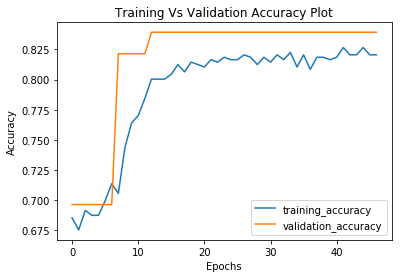

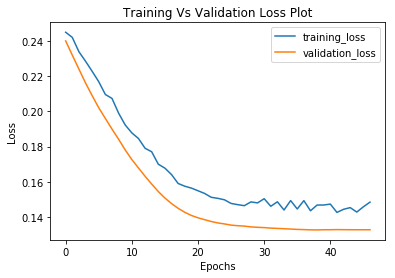

------------------------------------------------------------------------
Saving final model Final.hdf5


In [32]:
## Build a meta-classifier using Deep Neural Networks and train it on the PCs of the outputs of the base level models as features
# This is the second stage of the stacking ensemble technique, where the validation predictions from the previous ML models will be used as features

model = Sequential()
model.add(BatchNormalization(momentum=0.99, epsilon=0.001))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

# Select the optimizer and its parameters
sgd = optimizers.SGD(lr=0.01, momentum=0.90, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

# Set the callbacks for the DNN
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
ch = ModelCheckpoint('DLBestEnsemble.hdf5', monitor='acc', verbose=1, save_best_only=True, mode='max',period=1)
relr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001, mode='min', verbose=1, min_delta=1E-6)
callbacks_list = [es,ch,relr]

# Fit the model on train set
history = model.fit(X_train,y_train,epochs=5000, verbose=2, shuffle=True, batch_size=64, validation_split=0.1, callbacks=callbacks_list)
model.summary()

# Plot the progress charts
print('\nPerformance Charts\n')

pyplot.figure()

pyplot.plot(history.history['acc'], label='training_accuracy')
pyplot.plot(history.history['val_acc'], label='validation_accuracy')
pyplot.title('Training Vs Validation Accuracy Plot',loc='center')
pyplot.xlabel('Epochs')
pyplot.ylabel('Accuracy')
pyplot.legend()

pyplot.show()

pyplot.figure()

pyplot.plot(history.history['loss'], label='training_loss')    
pyplot.plot(history.history['val_loss'], label='validation_loss')
pyplot.title('Training Vs Validation Loss Plot')
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.legend()

pyplot.show() 
        
print('------------------------------------------------------------------------')

# Save the final trained model on the local disk
print('Saving final model Final.hdf5')
model.save("FinalEnsemble.hdf5")

In [33]:
# Evaluate model
model.evaluate(x=X_test,y=y_test)

62/62 [==============================] - 0s 81us/step


[0.16741244254573698, 0.7903225729542394]

In [34]:
# Make predictions on X_test
predictions = model.predict_classes(X_test)
predictions

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1], dtype=int64)

In [35]:
# Use argmax to select the prediction values from binary array y (Output from DL model trained above)
y_test.argmax(axis=1)

array([0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1], dtype=int64)

In [36]:
# Print confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test.argmax(axis=1),predictions))

[[ 7 12]
 [ 1 42]]


In [37]:
# Print a classification report
print(metrics.classification_report(y_test.argmax(axis=1),predictions))

              precision    recall  f1-score   support

           0       0.88      0.37      0.52        19
           1       0.78      0.98      0.87        43

   micro avg       0.79      0.79      0.79        62
   macro avg       0.83      0.67      0.69        62
weighted avg       0.81      0.79      0.76        62



In [38]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test.argmax(axis=1),predictions))

0.7903225806451613


In [39]:
# Use the final trained model to make predictions on test dataset for final submission
test_predictions = model.predict_classes(t)
test_predictions

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [40]:
# Import the test dataset and add predictions as the Loan_Status column
dft2 = pd.read_csv('test.csv')
dft2['Loan_Status'] = test_predictions

In [41]:
# Drop all the unnecessary columns
dft2 = dft2.drop(['Gender','Married','Dependents','Education','Self_Employed','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','Property_Area'],axis=1)
dft2.head()

,Loan_ID,Loan_Status
0,LP001015,1
1,LP001022,1
2,LP001031,1
3,LP001035,1
4,LP001051,1


In [42]:
# Convert the numeric predictions back to Y/N categorical predictions for final submission
dft2['Loan_Status'] = dft2['Loan_Status'].map(lambda x: 'Y' if x == 1 else 'N')
dft2.head()

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,Y


In [43]:
# Save the final predictions made using Advanced Stacking Ensemble technique
dft2.to_csv('Ensemble.csv', index=False)